In [2]:
%%writefile kaggle.json
{"username":"sairamparshi07","key":"a07ce4e9f16b95b9b0c358f5b12deec7"}

Writing kaggle.json


In [3]:
import os

def download_kaggle_dataset(dataset_path):
    # Kaggle dataset path example: 'grassknoted/asl-alphabet'
    # Ensure Kaggle API is installed
    os.system('pip install -q kaggle')

    # Check for kaggle.json file
    if not os.path.isfile('kaggle.json'):
        print("kaggle.json file not found. Please upload it.")
        return

    # Set up Kaggle directory and permissions
    os.system('mkdir -p ~/.kaggle')
    os.system('cp kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')

    # Download the dataset
    os.system(f'kaggle datasets download -d {dataset_path}')

    # Unzip the dataset
    zip_file = f'{dataset_path.split("/")[-1]}.zip'
    os.system(f'unzip -q {zip_file}')

# Example Usage:
download_kaggle_dataset('ashishjangra27/face-mask-12k-images-dataset')


In [4]:
import os
import glob
import pandas as pd

seed = 73

arr = []
path = "/content/Face Mask Dataset/"

for strat in os.listdir(path):
    for label in os.listdir(path+"/"+strat):
        for image in glob.glob(path+strat+"/"+label+"/"+"*.png"):
            arr.append({"path": image, "label": label, "strat": strat})


frame = pd.DataFrame(arr).sample(frac=1, random_state=seed)
print('> WithoutMask:', frame.value_counts("label")[0])
print('> WithMask:', frame.value_counts("label")[1])

frame

ModuleNotFoundError: No module named 'pandas'

## **Data preprocessing**

In [ ]:
IMG_SIZE = 128
input_shape=(IMG_SIZE, IMG_SIZE, 3)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255,
                             horizontal_flip=True,
                             brightness_range=[1.1, 1.3],
                             rotation_range=30,
                             #vertical_flip=True,
                             zoom_range=0.15
                             )

In [ ]:
def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          directory="../input",
                          x_col="path",
                          y_col="label",
                          batch_size=64,
                          seed=seed,
                          shuffle=False,
                          class_mode="binary",
                          target_size=(IMG_SIZE,IMG_SIZE))
    return generator

In [ ]:
train_df = frame[frame["strat"] == "Train"].sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

Found 10000 validated image filenames belonging to 2 classes.


In [ ]:
valid_df = frame[frame["strat"] == "Validation"].sample(frac=1, random_state=seed)
valid_generator = get_generator(valid_df)

Found 800 validated image filenames belonging to 2 classes.


In [ ]:
test_df = frame[frame["strat"] == "Test"].sample(frac=1, random_state=seed)
test_generator = get_generator(test_df)

Found 992 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential

final_activation = 'sigmoid'
entropy = 'binary_crossentropy'

In [ ]:
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output

    headModel = Dense(units=256)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Activation('relu')(headModel)
    headModel = Dropout(0.6, seed=73)(headModel)

    headModel = Dense(1, activation=final_activation)(headModel)
    model = Model(inputs = baseModel.input, outputs = headModel)

    return model

## **Xception Model**
**Reference**: https://stephan-osterburg.gitbook.io/coding/coding/ml-dl/tensorfow/ch3-xception/implementation-of-xception-model

![](https://miro.medium.com/max/2961/1*hOcAEj9QzqgBXcwUzmEvSg.png)

In [ ]:
def separable_conv_block(x, filters, block_num, conv_num, pre_activation=None):
    name = 'block{}_sepconv{}_'.format(block_num, conv_num)

    if pre_activation is True:
        x = Activation('relu', name=name+'act')(x)

    x = SeparableConv2D(filters, (3,3), padding='same', use_bias=False,
                        name=name)(x)

    x = BatchNormalization(name=name+'bn')(x)

    if pre_activation is False:
        x = Activation('relu', name=name+'act')(x)

    return x

In [ ]:
def middle_flow_block(x, filters, block_num):
    residual = x

    x = separable_conv_block(x, filters, block_num=block_num,
                             conv_num='1', pre_activation=True)

    x = separable_conv_block(x, filters, block_num=block_num,
                             conv_num='2', pre_activation=True)

    x = separable_conv_block(x, filters, block_num=block_num,
                             conv_num='3', pre_activation=True)

    return add([x, residual])

In [ ]:
def xception_block(x, filters, block_num, pre_activation=True):
    block = 'block{}_'.format(block_num)
    filter_conv1, filter_conv2 = filters

    residual = Conv2D(filter_conv2, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)

    residual = BatchNormalization()(residual)

    x = separable_conv_block(x, filter_conv1, block_num=block_num,
                             conv_num='1', pre_activation=pre_activation)

    x = separable_conv_block(x, filter_conv2, block_num=block_num,
                             conv_num='2', pre_activation=True)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name=block+'pool')(x)

    return add([x, residual])

In [ ]:
def conv_block(x, filters, block_num, conv_num, strides=(1,1)):
    name = 'block{}_conv{}_'.format(block_num, conv_num)

    x = Conv2D(filters, (3,3), strides=strides, use_bias=False, name=name)(x)
    x = BatchNormalization(name=name+'bn')(x)
    x = Activation('relu', name=name+'act')(x)

    return x

def Xception_Model():

    img_input = Input(shape=input_shape)

    x = conv_block(img_input, 32, block_num='1',
                   conv_num='1', strides=(2,2))

    x = conv_block(x, 64, block_num='1', conv_num='2')

    x = xception_block(x, (128, 128), '2', pre_activation=False)

    x = xception_block(x, (256, 256), '3')

    x = xception_block(x, (728, 728), '4')


    for i in range(8):
        block_num = str(5+i)
        x = middle_flow_block(x, 728, block_num)

    x = xception_block(x, (728, 1024), '13')

    x = separable_conv_block(x, 1536, block_num='14',
                             conv_num='1', pre_activation=False)

    x = separable_conv_block(x, 2048, block_num='14',
                             conv_num='2', pre_activation=False)

    x = GlobalAveragePooling2D(name='avg_pool')(x)

    model = Model(inputs=img_input, outputs=x, name='xception')

    model = FCLayers(model)

    model.summary()
    return model


model = Xception_Model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1_ (Conv2D)      (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 63, 63, 32)           128       ['block1_conv1_[0][0]']       
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 63, 63, 32)           0         ['block1_conv1_bn[0][0]'] 

## **Model Training**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(patience = 3, monitor='val_loss',
                                 mode='min', restore_best_weights=True,
                                 verbose = 1)

model_checkpoints = ModelCheckpoint("XceptionModel.h5",
                                    save_best_only=True, verbose = 1)


callbacks = [model_checkpoints, early_stopping]

In [ ]:
model.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])


history = model.fit(train_generator,validation_data  = valid_generator, epochs = 50,
                              steps_per_epoch=(len(train_generator.labels) / 80) ,
                              validation_steps=(len(valid_generator.labels) / 80),
                              callbacks = callbacks)

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9399
Epoch 1: val_loss improved from inf to 0.83612, saving model to XceptionModel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 115s 608ms/step - loss: 0.1571 - accuracy: 0.9399 - val_loss: 0.8361 - val_accuracy: 0.5078
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9754
Epoch 2: val_loss improved from 0.83612 to 0.73256, saving model to XceptionModel.h5
125/125 [==============================] - 69s 551ms/step - loss: 0.0677 - accuracy: 0.9754 - val_loss: 0.7326 - val_accuracy: 0.5078
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9834
Epoch 3: val_loss improved from 0.73256 to 0.67626, saving model to XceptionModel.h5
125/125 [==============================] - 70s 555ms/step - loss: 0.0523 - accuracy: 0.9834 - val_loss: 0.6763 - val_accuracy: 0.5719
Epoch 4/50
125/125 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9860
Epoch 4: val_loss improved from 0.67626 to 0.53687, saving model to XceptionModel.h5
125/125 [==============================] - 73s 583ms/s

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("XceptionModel.h5")

## **Model Evaluation**

In [ ]:
model.evaluate(test_generator, verbose=1)

16/16 [==============================] - 9s 534ms/step - loss: 0.0221 - accuracy: 0.9919


[0.02205299772322178, 0.9919354915618896]

In [ ]:
predictions = model.predict(test_generator, verbose = 1).round()

16/16 [==============================] - 8s 446ms/step


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
target_names = ['Has Mask','No Mask']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_results():
    print(classification_report(test_generator.labels, predictions, target_names=target_names))
    plt.figure(figsize = (8,5))
    sns.heatmap(confusion_matrix(test_generator.labels, predictions), annot = True,
                fmt="d",cmap = "Purples")
    plt.show()

    roc_acc = roc_auc_score(test_generator.labels, predictions)
    print('> ROC Accuracy: {}'.format(roc_acc.round(4)))

              precision    recall  f1-score   support

    Has Mask       0.99      0.99      0.99       483
     No Mask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



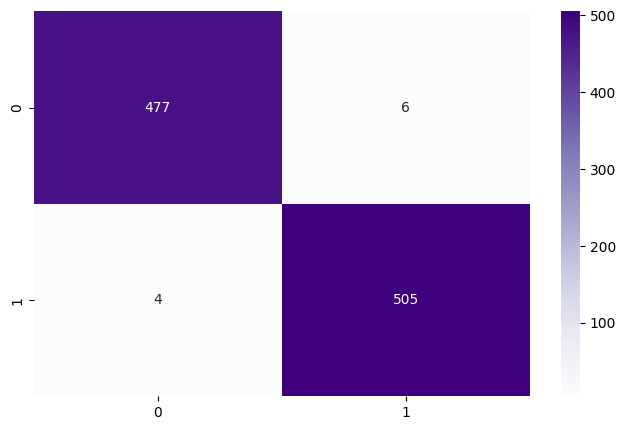

> ROC Accuracy: 0.9899


In [ ]:
print_results()

## **Face detection Model with Haar Cascade**

In [ ]:
import cv2
face_model = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

def getFaces(img):
    gray_img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = face_model.detectMultiScale(gray_img, scaleFactor=1.1,
                                        minNeighbors=8)
    return faces

In [ ]:
import PIL

def newSize(width, height):
    if width < 600:
        return newSize(width * 1.12 , height * 1.12)

    if width >= 1200:
        return newSize(width / 1.12 , height / 1.12)

    return int(width), int(height)

def AdjustSize(f):
    img = PIL.Image.open(f)
    width, height = img.size
    new_width, new_height = newSize(width, height)

    return (new_width, new_height)

In [ ]:
import numpy as np


def Draw(img, face):
    (x,y,w,h) = face
    mask_label = {0:'Has Mask!',1:'No Mask'}
    label_color = {0: (0,255,0), 1: (255,0,0)}

    crop = img[y:y+h,x:x+w]

    crop = cv2.resize(crop,(IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1,IMG_SIZE,IMG_SIZE,3]) / 255.0

    mask_result = model.predict(crop)

    pred_label = round(mask_result[0][0])

    cv2.putText(img,mask_label[pred_label],
                (x, y+90), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, label_color[pred_label], 2)

    cv2.rectangle(img,(x,y),(x+w,y+h),
                label_color[pred_label],1)

    return img

In [ ]:
from io import BytesIO
from skimage import io
from scipy.spatial import distance
import requests

MIN_DISTANCE = 0

def MaskDetection(imgUri):
    response = requests.get(imgUri)
    f = BytesIO(response.content)

    img = io.imread(f)
    resize = AdjustSize(f)
    img = cv2.resize(img, resize)
    faces = getFaces(img)

    if len(faces)>=1:
        label = [0 for i in range(len(faces))]

        for i in range(len(faces)-1):
            for j in range(i+1, len(faces)):
                dist = distance.euclidean(faces[i][:2],
                                          faces[j][:2])
                if dist < MIN_DISTANCE:
                    label[i] = 1
                    label[j] = 1

        for i in range(len(faces)):
            Draw(img, faces[i])

        plt.figure(figsize=(16,14))
        plt.imshow(img)

    else:
        print("No Face!")

1/1 [==============================] - 1s 1s/step


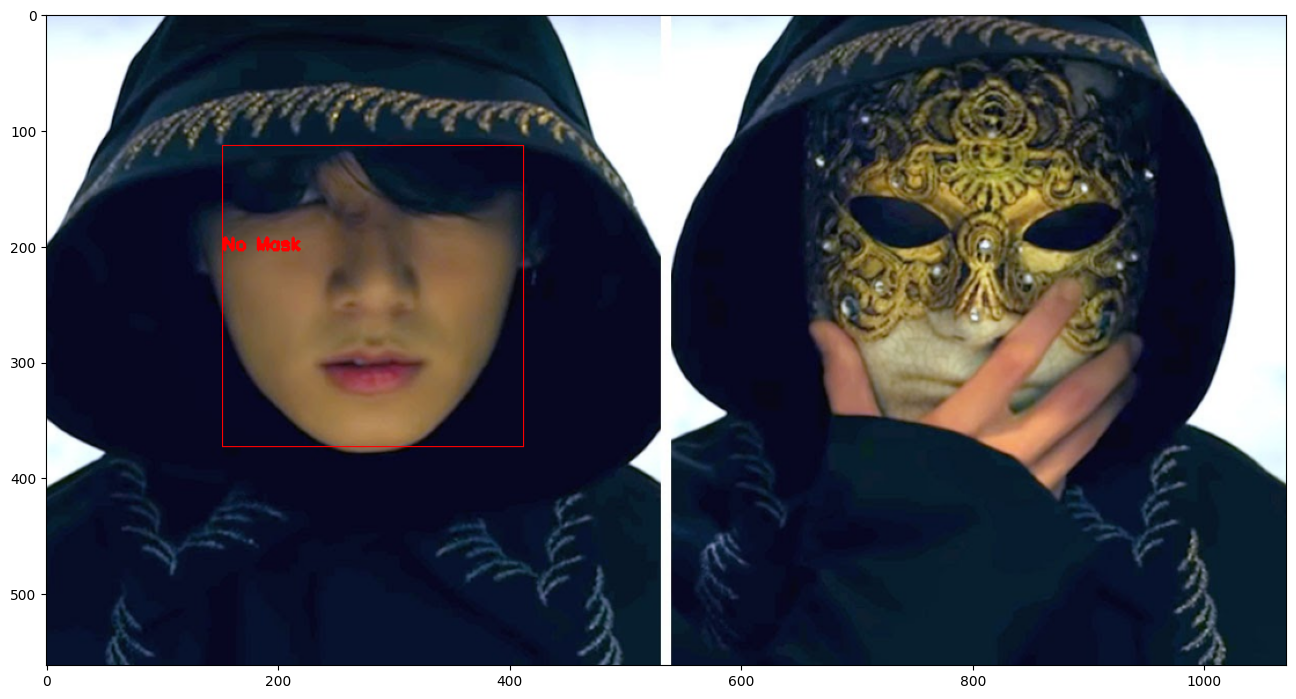

In [ ]:
MaskDetection("https://lh3.googleusercontent.com/xx2yn_8a0rQMqcib1BcZRAnzt70OjX2o8RnaoSx3L-RpgBd229jAAmTfCeRgmDwarCfTsglYWTldswEmsHehJvX2YW8dnKVNXw=w1200-h630-rj-pp-e365")

1/1 [==============================] - 0s 23ms/step


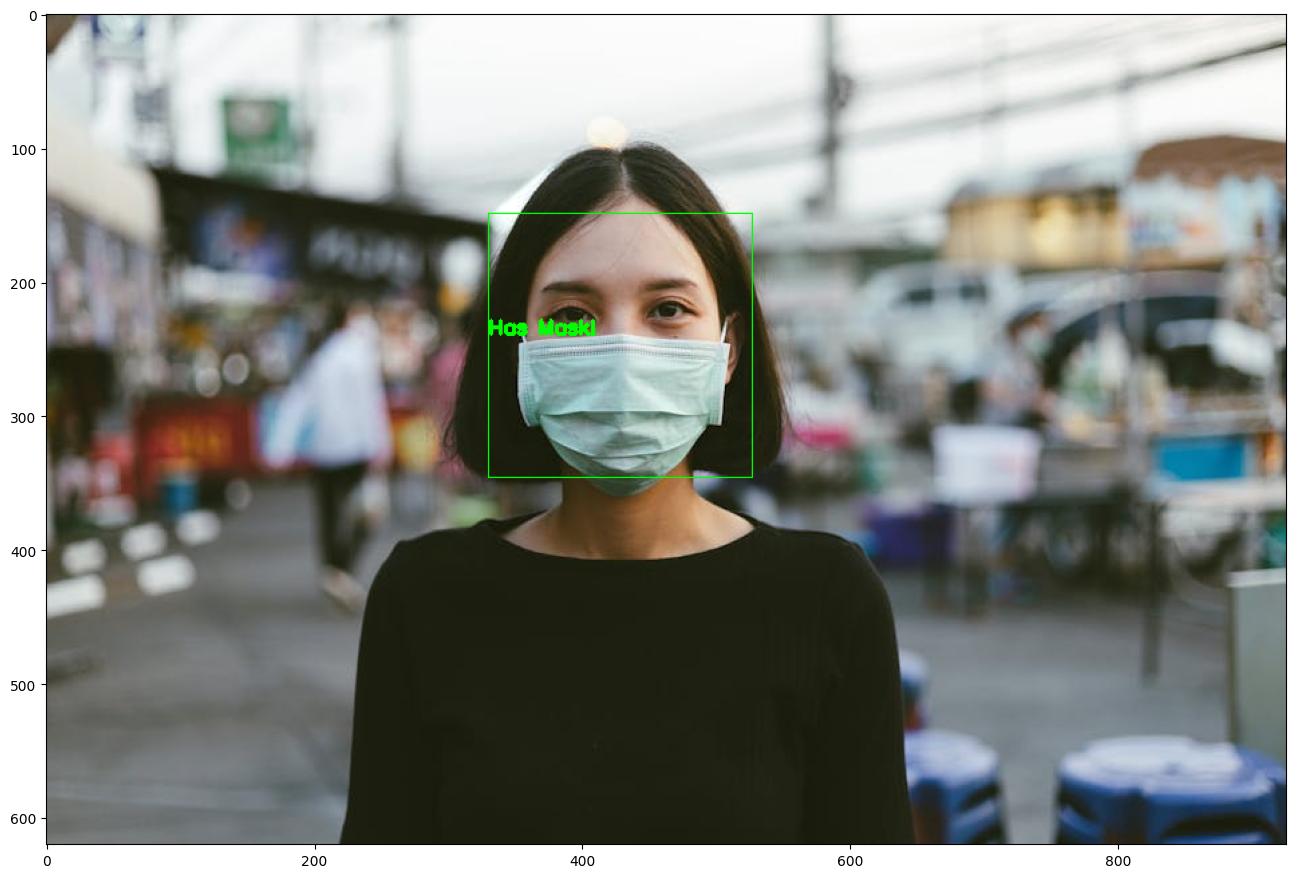

In [ ]:
MaskDetection("https://images.theconversation.com/files/326038/original/file-20200407-18916-1p3qplf.jpg?ixlib=rb-1.1.0&rect=17%2C0%2C5734%2C3837&q=45&auto=format&w=926&fit=clip")

1/1 [==============================] - 0s 30ms/step


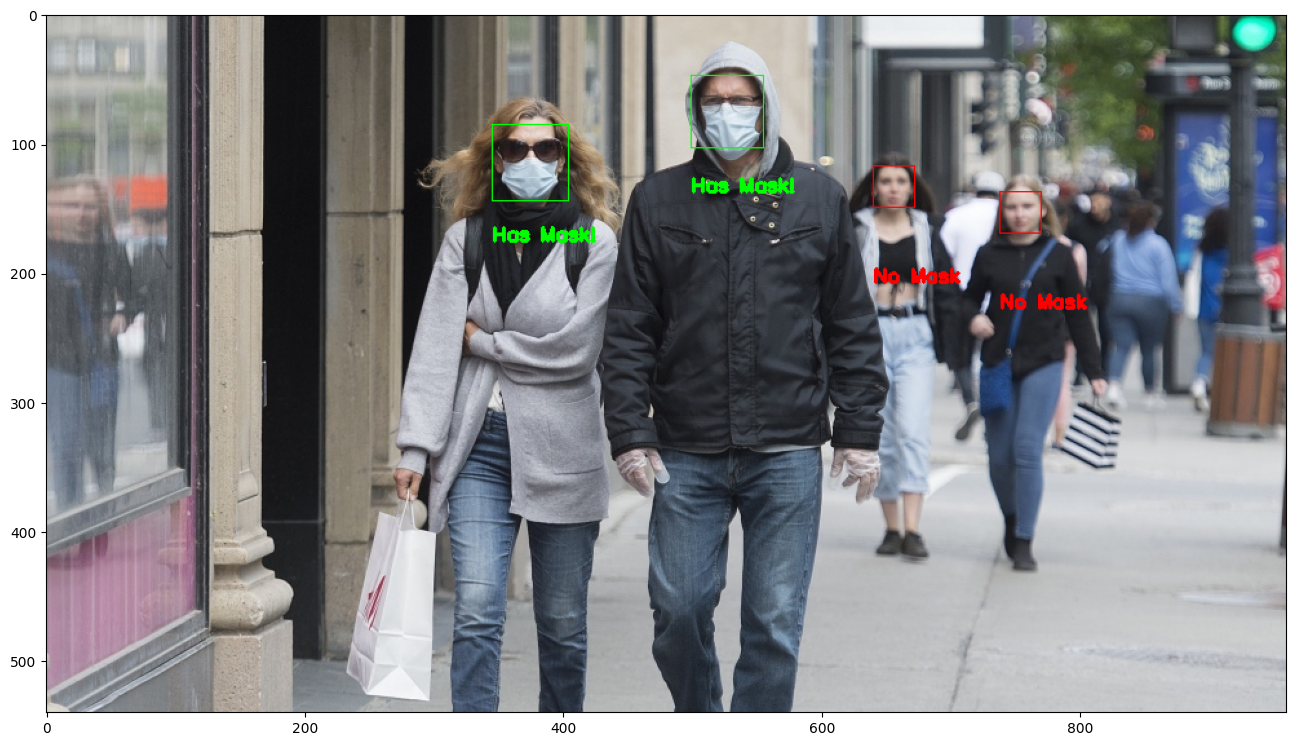

In [ ]:
MaskDetection("https://www.ctvnews.ca/polopoly_fs/1.4986740.1592334933!/httpImage/image.jpg_gen/derivatives/landscape_960/image.jpg")

1/1 [==============================] - 0s 20ms/step


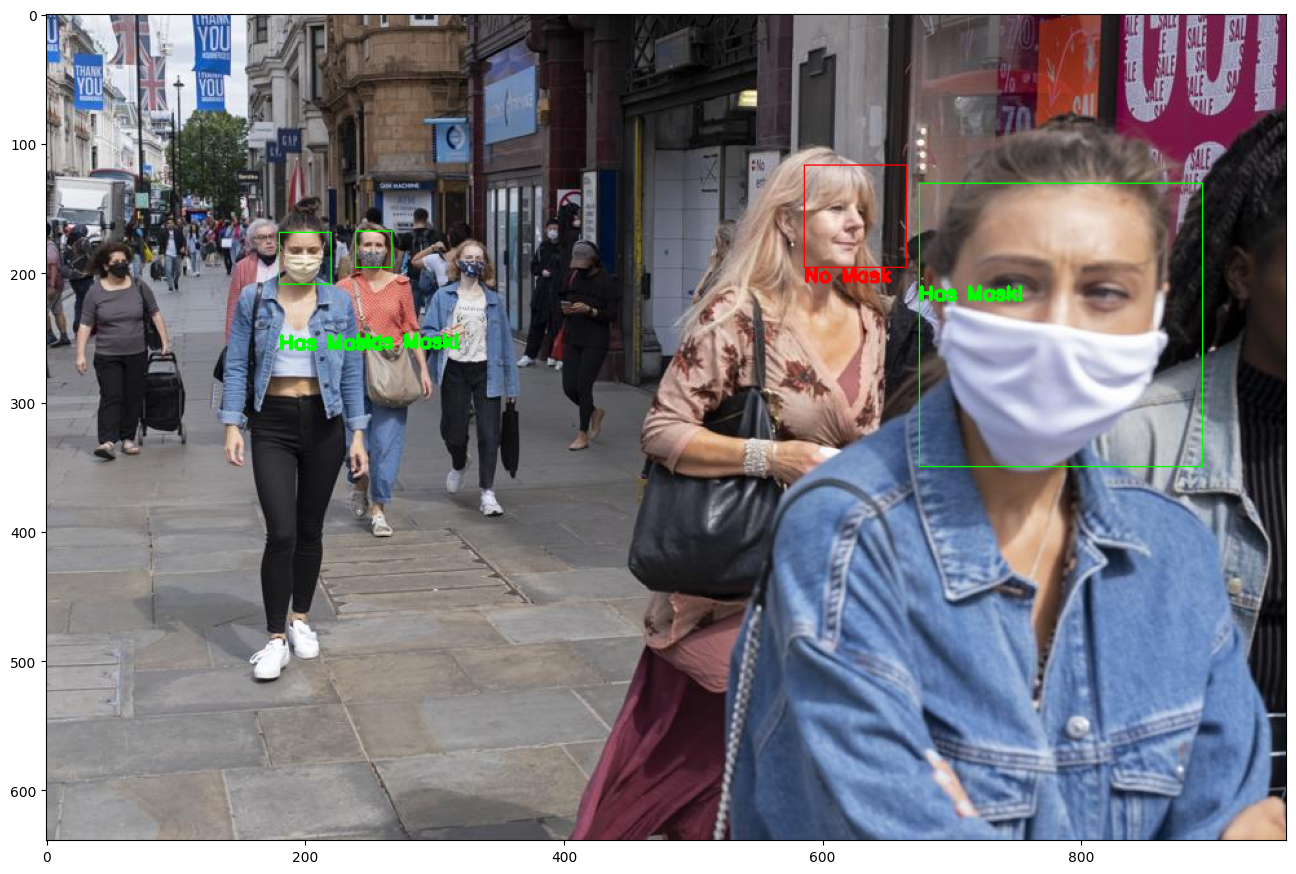

In [ ]:
MaskDetection("https://specials-images.forbesimg.com/imageserve/1227664783/960x0.jpg?fit=scale")

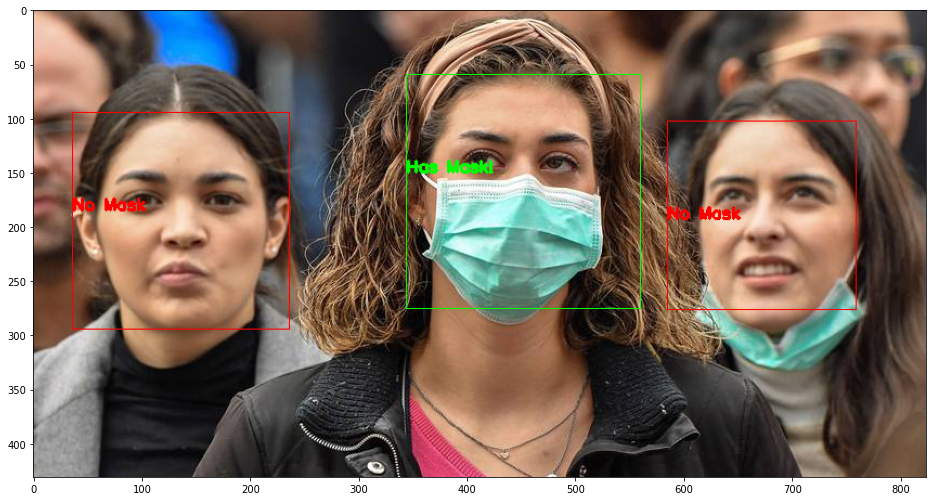

In [ ]:
MaskDetection("https://media.fromthegrapevine.com/assets/images/2020/3/coronavirus-mask-vatican-0302.jpg.824x0_q71_crop-scale.jpg")

In [ ]:
from IPython.display import FileLink
FileLink(r'./XceptionModel.h5')

/kaggle/working/XceptionModel.h5